# Load Data

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:


trDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (3835, 224, 224, 3), (3835,), (959, 224, 224, 3), (959,)


Showing 791 index image, It is 0.0


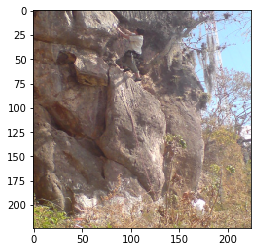

Showing 156 index image, It is 1.0


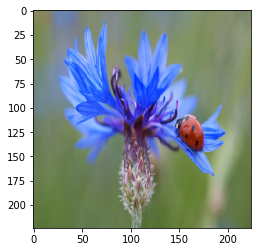

Showing 233 index image, It is 1.0


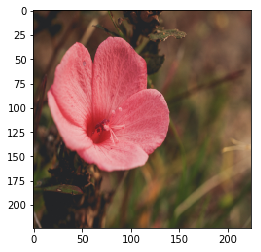

Showing 235 index image, It is 1.0


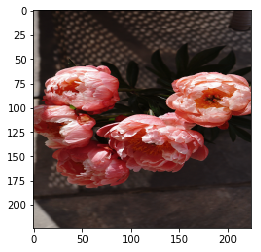

Showing 625 index image, It is 0.0


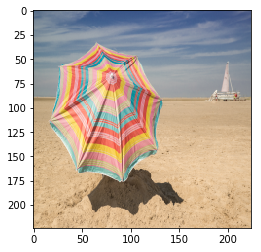

In [4]:
# Randomly show 5 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(5):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# # reshape the data to be [samples][width][height][channel]
# # This is required by Keras framework
# trDat       = trDat.reshape(trDat.shape[0], imgrows, imgclms, channel)
# tsDat       = tsDat.reshape(tsDat.shape[0], imgrows, imgclms, channel)

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

# Define Model

In [6]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

modelname = 'FlowerPower_VGG_Mod3'
optmz     = optimizers.RMSprop(lr=0.0001)

def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 110:
        lr  *= 1e-3
        
    elif epoch > 100:
        lr  *= 1e-2
        
    elif epoch > 70:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)
  
def createMod3VGGModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz,
                  metrics=['accuracy'])
    return model

model_mod3 = createMod3VGGModel()
model_mod3.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________

In [0]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath,  
                                  monitor='val_loss',
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')

# Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint, csv_logger, LRScheduler]

In [8]:
# Fit the model
# This is where the training starts
# model.fit(trDat, 
#           trLbl, 
#           validation_data=(tsDat, tsLbl), 
#           epochs=120, 
#           batch_size=16,
#           callbacks=callbacks_list)

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True,
                             vertical_flip=False)

model_mod3.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=120, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/120
120/119 [==============================] - 155s 1s/step - loss: 59.7542 - acc: 0.5478 - val_loss: 1.3690 - val_acc: 0.6017
Learning rate:  0.001
Epoch 2/120
120/119 [==============================] - 137s 1s/step - loss: 0.9403 - acc: 0.5528 - val_loss: 0.8213 - val_acc: 0.6277
Learning rate:  0.001
Epoch 3/120
120/119 [==============================] - 136s 1s/step - loss: 0.8119 - acc: 0.5692 - val_loss: 0.6834 - val_acc: 0.5704
Learning rate:  0.001
Epoch 4/120
120/119 [==============================] - 124s 1s/step - loss: 0.7362 - acc: 0.5585 - val_loss: 1.4386 - val_acc: 0.5610
Learning rate:  0.001
Epoch 5/120
120/119 [==============================] - 124s 1s/step - loss: 0.7604 - acc: 0.5593 - val_loss: 0.8279 - val_acc: 0.5673
Learning rate:  0.001
Epoch 6/120
120/119 [==============================] - 123s 1s/step - loss: 0.8121 - acc: 0.5593 - val_loss: 0.7201 - val_acc: 0.5641
Learning rate:  0.001
Epoch 7/120
120/119 [====================

In [0]:
## Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
model_mod3Go = createMod3VGGModel()
model_mod3Go.load_weights(filepath)
model_mod3Go.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [10]:
# Make classification on the test dataset
predicts    = model_mod3Go.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['flower', 'non-flower']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 88.43%
              precision    recall  f1-score   support

      flower     0.8744    0.8599    0.8671       421
  non-flower     0.8917    0.9033    0.8975       538

    accuracy                         0.8843       959
   macro avg     0.8831    0.8816    0.8823       959
weighted avg     0.8841    0.8843    0.8841       959

[[362  59]
 [ 52 486]]


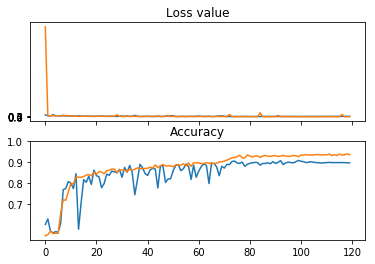

In [11]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.30, 0.4, 0.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

In [0]:
wrong_ans_index = []

for i in range(len(predout)):
    if predout[i] != testout[i]:
        wrong_ans_index.append(i)

In [0]:
wrong_ans_index = list(set(wrong_ans_index))

Showing 694 index image
Predicted as 1 but is actually 0


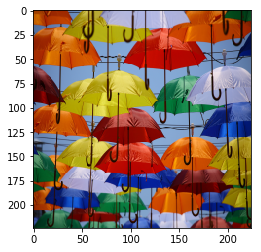

Showing 881 index image
Predicted as 1 but is actually 0


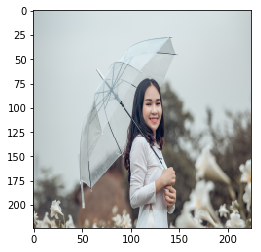

Showing 797 index image
Predicted as 1 but is actually 0


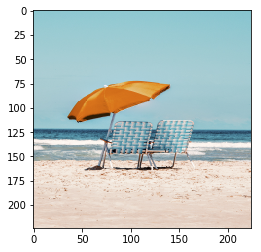

Showing 650 index image
Predicted as 1 but is actually 0


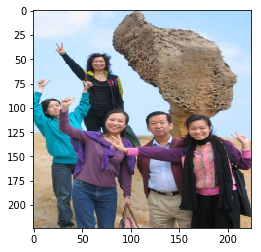

Showing 442 index image
Predicted as 0 but is actually 1


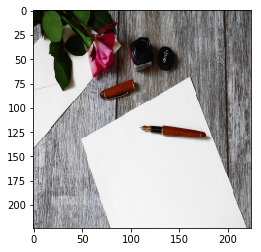

Showing 240 index image
Predicted as 0 but is actually 1


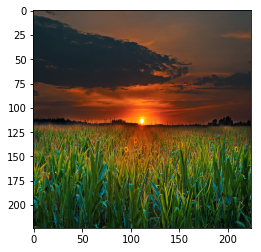

Showing 288 index image
Predicted as 0 but is actually 1


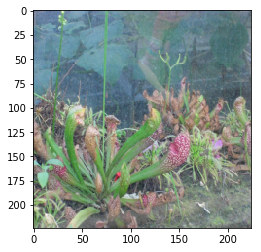

Showing 442 index image
Predicted as 0 but is actually 1


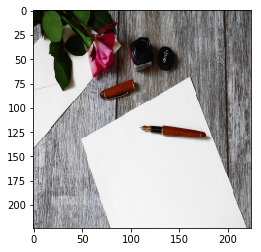

Showing 541 index image
Predicted as 1 but is actually 0


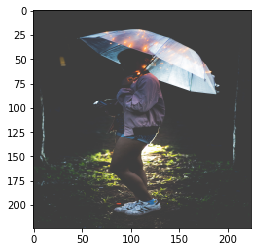

Showing 196 index image
Predicted as 0 but is actually 1


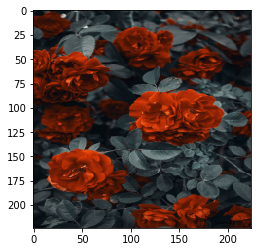

In [14]:
# Randomly show X examples of that was wrong

dataset = tsDatOrg #flowers #fungus #rocks

for index in range(10):
    index = wrong_ans_index[random.randint(0, len(wrong_ans_index)-1)]
    print("Showing %s index image" %(index))
    print("Predicted as %s but is actually %s" %(predout[index], testout[index]))
    imgplot = plt.imshow(data[index])
    plt.show()